# 好的，我们来系统地回顾一下**决策树模型的具体实现**。这将包括其核心算法步骤、关键概念以及如何使用代码实现。

### 决策树实现的核心思想

决策树的构建是一个**递归**的过程，遵循“分而治之”（Divide and Conquer）的策略。其根本目标是：选择最佳的特征和分割点，将数据集不断划分为纯度更高的子集，直到满足停止条件。

整个过程可以概括为以下三步：
1.  **特征选择**：在所有特征中，选择一个特征，使得根据这个特征分裂后，数据集的“不纯度”下降最多。
2.  **节点分裂**：根据选定的特征及其分割点，将当前节点分裂为2个或更多个子节点。
3.  **递归进行**：对每个子节点重复步骤1和2，直到满足**停止条件**。

---

### 一、 关键概念与算法细节

#### 1. 特征选择的衡量标准

如何量化“不纯度”的下降？这依赖于以下指标：

**a) 信息增益 (Information Gain) - 基于熵 (Entropy)**
*   **熵**：表示随机变量的不确定性（混乱程度）。熵越大，不确定性越大。
    $Entropy(D) = -\sum_{i=1}^{k} p_i \log_2(p_i)$
    其中 $D$ 是数据集，$p_i$ 是第 $i$ 类样本在 $D$ 中所占的比例，$k$ 是类别数。
    *   例：一个节点中有10个样本，5个是/5个否，则熵为 $-(\frac{5}{10}\log_2\frac{5}{10} + \frac{5}{10}\log_2\frac{5}{10}) = 1$（非常不纯）。
    *   如果10个全是“是”，则熵为 $-(\frac{10}{10}\log_2\frac{10}{10}) = 0$（非常纯）。

*   **信息增益**：使用特征 $A$ 对数据集 $D$ 进行划分后，熵的减少量。**我们选择信息增益最大的特征。**
    $Gain(D, A) = Entropy(D) - \sum_{v=1}^{V} \frac{|D^v|}{|D|} Entropy(D^v)$
    其中 $V$ 是特征 $A$ 的取值个数（例如，“天气”特征有“晴、雨、阴”3种取值），$D^v$ 是 $D$ 中在特征 $A$ 上取值为 $v$ 的样本子集。

**b) 基尼指数 (Gini Index)**
*   **基尼值**：表示从数据集中随机抽取两个样本，其类别标记不一致的概率。基尼值越小，纯度越高。
    $Gini(D) = 1 - \sum_{i=1}^{k} p_i^2$
    *   例：同样是10个样本（5是/5否），基尼值为 $1 - [(\frac{5}{10})^2 + (\frac{5}{10})^2] = 0.5$。

*   **基尼指数**：与信息增益类似，我们选择划分后能使**基尼指数减小最多**（即加权平均基尼值最小）的特征。
    $Gini\_index(D, A) = \sum_{v=1}^{V} \frac{|D^v|}{|D|} Gini(D^v)$

> **区别**：
> *   信息增益对可取值数目多的特征有偏好（例如“ID”特征，每个样本一个值，分裂后熵为0，信息增益最大，但这没用）。
> *   **C4.5算法**使用**信息增益率**来修正这个问题。
> *   **CART算法**（Scikit-learn的实现）默认使用**基尼指数**，因为它计算更快且不需要对数运算。

#### 2. 节点的分裂方式

*   **离散特征（分类数据）**：
    *   **二元分裂**：例如“是否为学生？”（是/否）。这是CART树的做法。
    *   **多元分裂**：例如“天气”直接分成（晴、雨、阴）三个分支。这是ID3、C4.5的做法。
*   **连续特征（数值数据）**：
    *   需要找到一个**最佳分割点**。
    *   步骤：1) 将该特征的所有值排序； 2) 尝试所有相邻值的中点作为候选分割点； 3) 计算以每个候选点分裂后的信息增益或基尼指数； 4) 选择最优的那个分割点。

#### 3. 递归停止条件

为了避免树无限生长（过拟合），必须设定停止条件：
*   当前节点包含的样本数少于预设的最小值。
*   所有样本都属于同一类别（纯度已为0）。
*   所有样本的特征值都相同。
*   树的深度达到预设的最大深度。
*   分裂带来的性能提升（如信息增益）小于某个阈值。

#### 4. 剪枝 (Pruning)

构建完一棵完整的树后，为了缓解过拟合，需要进行剪枝，即去掉一些不必要的子树。
*   **预剪枝**：在树构建的过程中，如果当前节点的划分不能带来**验证集**性能的提升，就停止划分。简单高效，但可能“贪心”地错过后续可能更好的划分。
*   **后剪枝**：先构建一棵完整的树，然后自底向上，考察非叶节点。如果将其替换为叶节点能带来验证集性能的提升，则进行替换。性能通常优于预剪枝，但训练开销更大。

---

### 二、 代码实现（使用Scikit-learn）

Scikit-learn提供了非常高效且易用的决策树实现。

#### 1. 分类树 (`DecisionTreeClassifier`)

```python
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# 1. 加载数据
iris = load_iris()
X = iris.data
y = iris.target

# 2. 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. 创建模型并设置关键超参数
#    criterion: 特征选择标准 ('gini' or 'entropy')
#    max_depth: 树的最大深度，防止过拟合
#    min_samples_split: 内部节点再划分所需最小样本数
#    min_samples_leaf: 一个叶子节点最少需要的样本数
clf = DecisionTreeClassifier(criterion='gini',
                             max_depth=3,
                             random_state=42)

# 4. 训练模型
clf.fit(X_train, y_train)

# 5. 评估模型
accuracy = clf.score(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# 6. 可视化决策树 (非常重要!)
plt.figure(figsize=(12, 8))
plot_tree(clf,
          feature_names=iris.feature_names,
          class_names=iris.target_names,
          filled=True, # 用颜色填充节点，表示类别
          rounded=True)
plt.title("Decision Tree Visualization on Iris Dataset")
plt.show()
```

#### 2. 回归树 (`DecisionTreeRegressor`)

用于预测连续值。其分裂标准不再是基尼系数或熵，而是**MSE（均方误差）**或**MAE（平均绝对误差）**。分裂的目标是使得子节点的样本值尽可能接近（方差小）。

```python
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# 假设我们有一个回归数据集 X_reg, y_reg
# ...

regressor = DecisionTreeRegressor(criterion='squared_error', # 使用MSE
                                  max_depth=5)
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {mse:.4f}")
```

---

### 三、 实现决策树的要点总结

| 方面 | 实现细节 |
| :--- | :--- |
| **核心算法** | **ID3** (使用信息增益), **C4.5** (使用信息增益率), **CART** (使用基尼指数，可做分类和回归)。Scikit-learn使用CART算法。 |
| **关键步骤** | 1. 特征选择（计算信息增益/基尼指数）<br>2. 节点分裂（离散值、连续值）<br>3. 递归构建<br>4. （可选）剪枝 |
| **超参数** | **`max_depth`**：控制复杂度，防过拟合。<br>**`min_samples_split`** / **`min_samples_leaf`**：限制节点规模。<br>**`criterion`**：选择分裂标准（`gini`或`entropy`）。 |
| **优点** | 直观易解释；需很少数据预处理；能处理非线性关系。 |
| **缺点** | **极易过拟合**（必须通过`max_depth`等参数严格控制）；**不稳定**（数据微小变化可能导致树结构巨变）。 |
| **解决方案** | 通过**集成学习**（如随机森林、GBDT）将多棵决策树组合起来，克服其缺点，构建强大且稳定的模型。 |

希望这次回顾能帮助你更牢固地掌握决策树模型的实现原理和细节！

Test Accuracy: 1.0000


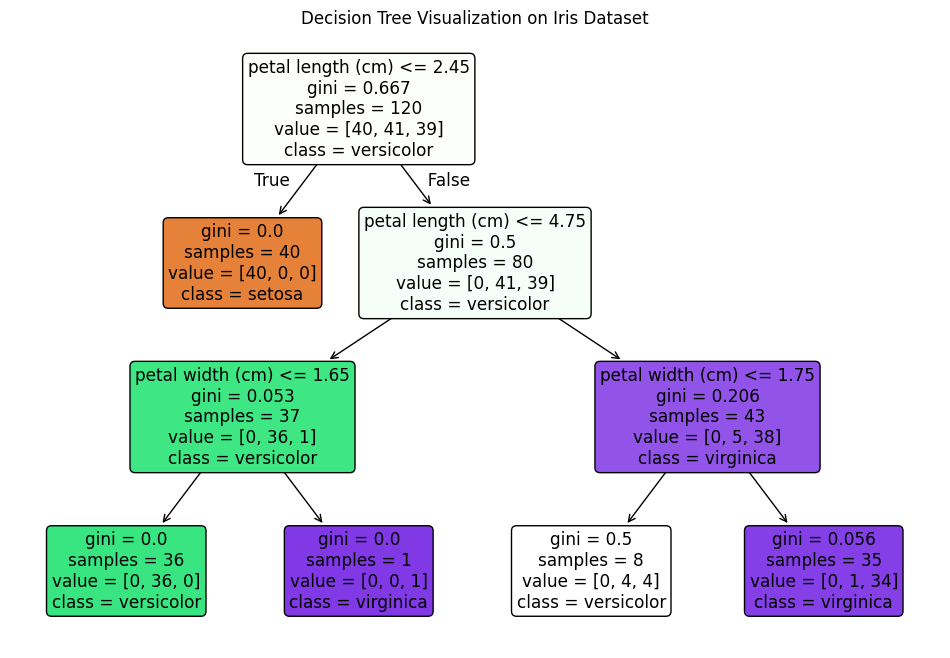

In [1]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# 1. 加载数据
iris = load_iris()
X = iris.data
y = iris.target

# 2. 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. 创建模型并设置关键超参数
#    criterion: 特征选择标准 ('gini' or 'entropy')
#    max_depth: 树的最大深度，防止过拟合
#    min_samples_split: 内部节点再划分所需最小样本数
#    min_samples_leaf: 一个叶子节点最少需要的样本数
clf = DecisionTreeClassifier(criterion='gini',
                             max_depth=3,
                             random_state=42)

# 4. 训练模型
clf.fit(X_train, y_train)

# 5. 评估模型
accuracy = clf.score(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# 6. 可视化决策树 (非常重要!)
plt.figure(figsize=(12, 8))
plot_tree(clf,
          feature_names=iris.feature_names,
          class_names=iris.target_names,
          filled=True, # 用颜色填充节点，表示类别
          rounded=True)
plt.title("Decision Tree Visualization on Iris Dataset")
plt.show()

当然。**分类树的目的**非常直观和明确：

**其核心目的是通过学习一系列简单的“if-then-else”决策规则，从数据特征中预测出一个离散的类别标签。**

简单来说，它就像一个**自动化的问卷调查**或**流程图**，通过提出一连串关于数据特征的是非题，最终将样本引导至一个结论（即其预测类别）。

---

### 详细分解

我们可以从以下几个层面来深入理解分类树的目的：

#### 1. 核心目标：分类与预测
*   **分类**：将样本划分到预先定义好的几个类别中。例如：
    *   根据天气情况（特征）预测是否适合打网球（类别：是/否）。
    *   根据花瓣和萼片的尺寸（特征）预测鸢尾花的种类（类别：山鸢尾、变色鸢尾、维吉尼亚鸢尾）。
    *   根据财务和历史行为数据（特征）预测贷款申请人的风险等级（类别：低风险、中风险、高风险）。
*   **预测**：对于一个全新的、未见过的样本，模型能够根据学到的规则给出一个类别预测。

#### 2. 过程目的：生成可解释的决策规则
分类树不仅仅是为了得到一个预测结果，更重要的是**生成一个清晰、可理解的决策过程**。这与“黑盒”模型（如深度学习神经网络）形成鲜明对比。

*   **可解释性**：你可以轻松地查看和解释整个决策路径。
    *   **例如**：模型判断一个人“不会购买产品”的原因可能是：`IF 年龄 > 30 AND 曾经访问网站次数 < 5 THEN 不购买`。这个决策逻辑业务人员很容易理解。
*   **可视化**：整个模型可以画成一棵倒立的树，从根节点到叶节点的每一条路径都是一条清晰的决策规则。这在向非技术人员解释模型时具有巨大优势。

#### 3. 技术目的：最大化“纯度”
在构建树的过程中，其内在的技术目的是在每一个节点上，找到最优的特征和分割点，使得分裂后的子节点尽可能“纯”。

*   **“纯度”**：指的是一个节点中样本属于**同一类别**的程度。
*   **如何实现**：通过优化指标（如**基尼不纯度**或**信息增益**）来选择最佳分割特征。算法的目标是让分裂后子节点的基尼不纯度总和**最小**（或者说让信息增益**最大**）。

#### 4. 应用目的：解决特定类型的问题
分类树特别适合解决以下情况：
*   **问题是非线性的**：特征和目标类别之间的关系不能用一条直线简单划分。
*   **特征交互作用复杂**：例如，“只有当特征A成立**且**特征B不成立时，结果才为真”。决策树能自然地捕捉这种交互效应。
*   **需要模型可解释性**：在医疗、金融、法律等领域，知道“为什么”做出这个预测和预测本身同样重要。

---

### 一个简单的例子：判断是否适合打网球

假设我们有以下数据：

| 天气 | 温度 | 湿度 | 风力 | 是否打网球 |
| :--- | :--- | :--- | :--- | :--- |
| 晴 | 高 | 高 | 弱 | 否 |
| 晴 | 高 | 高 | 强 | 否 |
| 阴 | 高 | 高 | 弱 | 是 |
| 雨 | 中 | 高 | 弱 | 是 |
| 雨 | 低 | 正常 | 弱 | 是 |
| 雨 | 低 | 正常 | 强 | 否 |
| 阴 | 低 | 正常 | 强 | 是 |

**分类树的目的**就是根据前四个特征（天气、温度、湿度、风力）自动构建一棵类似下图的决策树：

```
                     [天气?]
                   /     |     \
                 /       |       \
            [晴]       [阴]       [雨]
             /           |           \
        [湿度?]        [是]        [风力?]
         /   \                      /   \
     [高]   [正常]               [强]   [弱]
      /         \                 /         \
    [否]       [是]            [否]        [是]
```

**这棵树的目的是**：提供一套规则来预测新的一天是否适合打网球。
*   如果新的一天是`阴天`，模型会直接预测`是`。
*   如果新的一天是`晴天`，模型会继续询问`湿度高吗？`，如果湿度高则预测`否`，湿度正常则预测`是`。

### 总结

| 层面 | 分类树的目的 |
| :--- | :--- |
| **核心** | 预测离散的类别标签。 |
| **过程** | 生成一套清晰、可解释的“if-then-else”决策规则。 |
| **技术** | 通过优化纯度指标（如基尼不纯度），找到最佳的数据划分方式。 |
| **应用** | 解决非线性、有特征交互作用、且需要可解释性的问题。 |
| **最终** | **将一个复杂的分类问题，转化为一系列简单的、基于特征的判断。** |

因此，分类树不仅仅是一个预测模型，更是一个**知识发现**和**决策过程可视化**的强大工具。这也是为什么它是数据科学中最基础、最受欢迎的算法之一。

# 好的，我们来详细介绍一下**回归树（Regression Tree）**。

回归树是决策树家族中用于解决**回归问题**的模型。它的核心思想与分类树非常相似，但其目标和实现细节有关键区别。

### 一、核心思想与目的

**核心思想：** 将特征空间（即数据集）划分成若干个简单且互不重叠的区域，然后用一个简单的常数（通常是该区域内所有样本目标值的平均值）来代表这个区域内样本的预测值。

**目的：** 预测一个**连续的数值**，而不是一个离散的类别。例如：
*   预测房屋价格
*   预测气温
*   预测销售额
*   预测用户生命周期价值

你可以把它想象成一个**分段常数函数**或一个**多阶的阶梯函数**。整个模型的目的就是找到最佳的分割方式，使得这个“阶梯”能够最好地拟合数据。

---

### 二、与分类树的区别

理解回归树的关键在于看清它与分类树的不同之处：

| 特性 | 分类树 (Classification Tree) | 回归树 (Regression Tree) |
| :--- | :--- | :--- |
| **预测目标** | **离散的类别标签** (如：是/否，猫/狗/鸟) | **连续的数值** (如：房价 42.5万，温度 23.4°C) |
| **叶节点的值** | 节点中样本的**多数类** (Mode) | 节点中样本目标值的**平均值** (Mean) |
| **分裂标准** | 最大化**纯度**下降 (使用**基尼系数**或**熵**) | 最大化**不纯度**下降 (使用**方差**或**MSE**) |
| **模型输出** | 一个类别标签 | 一个具体的数值 |

---

### 三、算法原理与构建过程

回归树的构建同样是一个递归的、贪婪的二分过程。其核心问题是：**“如何选择最佳的特征和分割点？”**

#### 1. 选择最佳分割的特征和点

回归树不再使用基尼系数或熵，而是使用**基于方差的指标**来衡量一个节点的“不纯度”。

*   **节点的不纯度**：使用**均方误差 (MSE)** 或**方差**来衡量。
    对于一个节点 $R_m$ 包含 $N_m$ 个样本，其不纯度计算为该节点内所有样本的方差（或MSE）：
    `MSE(R_m) = (1/N_m) * Σ (y_i - c_m)^2`
    其中，$c_m$ 是节点 $R_m$ 内所有样本 $y_i$ 的**平均值**。

*   **寻找最佳分割**：
    对于每一个特征 $j$ 和每一个可能的分割点 $s$（对于连续特征，通常是所有可能的中点），我们将当前节点 $R$ 划分为两个子区域：
    *   $R_1(j, s) = \{X \| X_j <= s\}$
    *   $R_2(j, s) = \{X \| X_j > s\}$

    然后，我们计算分割后两个子区域的**MSE之和**。我们的目标是找到那个**使得MSE减少最多**的特征 $j$ 和分割点 $s$。换句话说，就是最小化分裂后的子节点MSE之和：

    `min (MSE(R_1) + MSE(R_2))`

    **选择标准可以理解为：选择那个能让分裂后的两个区域内部样本值都尽可能“接近”的特征和分割点。**

#### 2. 递归构建与停止条件

*   **递归**：对第一步中得到的两个子区域 $R_1$ 和 $R_2$，递归地重复上述分割过程。
*   **停止条件**（与分类树类似）：
    *   树达到最大深度 (`max_depth`)
    *   节点中包含的样本数小于某个最小值 (`min_samples_split`)
    *   分裂带来的MSE减少量小于某个阈值 (`min_impurity_decrease`)
    *   所有样本的特征值都相同

#### 3. 预测

当一棵回归树构建完成后，对于一个新样本的预测非常简单：
1.  从根节点开始，根据样本的特征值，沿着树的分支规则向下移动。
2.  最终到达一个**叶节点**。
3.  将该叶节点内所有训练样本目标值的**平均值**作为这个新样本的预测值。

---

### 四、一个简单的例子：预测房屋价格

假设我们有一个非常小的数据集，只有一个特征 `房屋面积（平米）`：

| 面积 (平米) | 价格 (万元) |
| :--- | :--- |
| 50 | 55 |
| 60 | 62 |
| 70 | 78 |
| 80 | 81 |
| 90 | 92 |
| 100 | 105 |

**回归树的构建可能如下：**

1.  **寻找最佳分割点**：算法尝试所有可能的分割点（例如55, 65, 75, 85, 95）。
    *   假设在 **75** 处分割：左节点包含面积<=75的房子（价格55, 62, 78），右节点包含面积>75的房子（价格81, 92, 105）。
    *   计算左节点的平均值 `c_left = (55+62+78)/3 = 65`
    *   计算右节点的平均值 `c_right = (81+92+105)/3 ≈ 92.67`
    *   计算分裂后的MSE之和：`MSE_left = [(55-65)^2 + (62-65)^2 + (78-65)^2] / 3` + `MSE_right = ...`

    算法会发现，选择 `75` 作为分割点能最大程度地降低MSE。

2.  **生成树结构**：
    ```
    [所有数据] (均价: (55+62+78+81+92+105)/6 ≈ 78.83)
        |
        |--- IF 面积 <= 75 ? ---> [左节点] (预测值: 65)
        |--- IF 面积 > 75 ? --->  [右节点] (预测值: 92.67)
    ```
    这已经是一棵深度为1的回归树（也称为**树桩**）。

3.  **进行预测**：现在有一个新房子，面积是 `73` 平米。
    *   因为 73 <= 75，所以被分到左节点。
    *   模型的预测价格就是左节点的值：**65万元**。

如果我们将树构建得更深（例如允许再次分裂），模型就能生成更精细的“阶梯”，拟合能力更强，但也更容易过拟合。

---

### 五、在Scikit-learn中的实现

Scikit-learn 通过 `DecisionTreeRegressor` 类实现回归树。

```python
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd

# 假设 df 是包含特征和目标值 'Price' 的DataFrame
# X = df[['Feature1', 'Feature2', ...]]
# y = df['Price']

# 1. 划分数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. 创建回归树模型
#    关键超参数：
#    - criterion: 分裂标准，默认为 'squared_error' (MSE)
#    - max_depth: 最大深度，控制复杂度，防止过拟合
#    - min_samples_split: 节点最小分裂所需样本数
reg_tree = DecisionTreeRegressor(max_depth=3, random_state=42)

# 3. 训练模型
reg_tree.fit(X_train, y_train)

# 4. 预测并评估
y_pred = reg_tree.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {mse:.4f}")

# 5. 可视化树（对于深度小的树很有用）
plt.figure(figsize=(20, 10))
plot_tree(reg_tree,
          feature_names=X.columns, # 显示特征名
          filled=True,      # 用颜色填充，表示数值高低
          rounded=True)
plt.show()
```

### 六、优缺点

**优点：**
*   **易于理解和解释**：规则清晰，可可视化。
*   **需要的数据预处理少**：对数据分布、量纲不敏感，可以处理缺失值。
*   **能够捕捉非线性关系**。
*   **是强大集成模型的基础**（如**随机森林**和**梯度提升树(GBDT)** 在做回归任务时，其中的基学习器就是回归树）。

**缺点：**
*   **预测能力有限**：单个回归树的预测精度通常不高，因为它是一个简单的分段常数模型，无法提供非常平滑的预测。
*   **不稳定**：训练数据的微小变化可能导致生成完全不同的树。
*   **容易过拟合**：如果不通过 `max_depth` 等参数进行剪枝，树会一直生长直到记住所有噪声。

### 总结

回归树是一种通过递归地**二分数据**、**最小化区域内部方差（MSE）** 来预测连续值的模型。它将复杂的回归问题转化为一系列简单的决策规则，最终用**叶节点内样本的平均值**作为预测输出。虽然单一回归树能力较弱，但它是构建当今最强大的机器学习模型（如梯度提升树）不可或缺的基石。

# 好的，我们来深入详细地介绍一下**梯度提升决策树（Gradient Boosting Decision Trees, GBDT）** 及其算法原理。GBDT是机器学习中最强大、最常用的算法之一，在各类数据科学竞赛和工业界应用中取得了巨大成功。

### 一、GBDT 的核心思想

GBDT 属于 **集成学习（Ensemble Learning）** 中的 **Boosting** 流派。它的核心思想非常直观：

> **“三个臭皮匠，顶个诸葛亮”**

具体来说，GBDT 通过组合多个**弱学习器**（通常是深度较小、简单的决策树，也称为**基学习器**），来构建一个强大的**强学习器**。它的关键不在于并行训练（如随机森林的Bagging），而在于**序列化地训练**：每一棵树都在学习**前一棵树留下的错误（残差）**，通过不断修正错误，使得整个模型的预测能力越来越强。

你可以用一个生动的比喻来理解：
> **考试复习**：你第一次做模拟题，得了70分。你重点分析了错的30分题目（**残差**）。第二次复习，你专门针对这些错题对应的知识点进行学习（**拟合残差**）。第二次考试，你可能得了85分。你再分析这次错的15分题目，继续强化这些薄弱环节。如此反复几次，你的成绩就会越来越接近100分。GBDT就是这个不断“查漏补缺”的过程。

### 二、算法原理详解

GBDT 是 **Gradient Boosting** 框架的一种实现，它使用**决策树**作为其基学习器。其算法的精髓在于将** boosting ** 和 **梯度下降（Gradient Descent）** 在函数空间巧妙地结合了起来。

#### 1. 核心概念：从梯度下降说起

理解GBDT的关键是理解**在函数空间中的梯度下降**。

*   **模型空间中的梯度下降**：
    在训练神经网络时，我们有一个损失函数 `L(y, F(x))`，其中 `F(x)` 是模型的预测输出。我们通过 `F(x) ← F(x) - η * ∇F L` 来更新模型参数，`∇F L` 是损失函数对模型**参数**的梯度。我们是在**参数空间**中沿梯度反方向移动，最小化损失。

*   **函数空间中的梯度下降**：
    在Boosting中，我们将整个模型 `F(x)` 本身看作一个“参数”。我们的目标是直接寻找一个最优函数 `F*(x)` 来最小化损失。每一步，我们不是更新参数，而是**给当前模型增加一个新函数（一棵树）`h(x)`**，这个新函数的方向应该是损失函数对当前模型 `F(x)` 的**负梯度方向**。
    模型更新公式变为：`F_{m}(x) = F_{m-1}(x) - η * h_m(x)`
    这里的 `h_m(x)` 就是要拟合的负梯度。

#### 2. GBDT 算法步骤（回归问题）

假设我们有数据集 `(x_i, y_i), i=1...N`，损失函数为 `L(y, F(x))`（例如均方误差 MSE）。

**第一步：初始化模型**
用一个简单的常数来初始化第一个弱学习器，这个常数是能够最小化损失函数的值。
对于MSE损失，就是目标值的均值。
`F₀(x) = argmin_γ Σ L(y_i, γ) = mean(y)`

**第二步：循环迭代 For m = 1 to M: (M是树的总数)**
1.  **计算伪残差（负梯度）**
    对于每一个样本 `i = 1,2,...,N`，计算当前模型下的负梯度（即伪残差），它就是损失函数关于当前预测值 `F_{m-1}(x_i)` 的导数的负值。
    `r_{im} = - [∂L(y_i, F(x_i)) / ∂F(x_i)]_{F(x)=F_{m-1}(x)}`
    *   **对于均方误差损失函数 `L = (y - F(x))²/2`：**
        `r_{im} = - [ ∂( (y_i - F(x_i))²/2 ) / ∂F(x_i) ] = y_i - F_{m-1}(x_i)`
        这正好就是**残差**！这解释了为什么说GBDT是在拟合残差。

2.  **训练一棵新树**
    用当前的数据 `(x_i, r_{im})` 而不是原始数据 `(x_i, y_i)` 来训练一棵新的决策树 `h_m(x)`。这棵树的目标是拟合上一步计算出的伪残差。这棵树的叶子节点会被划分成 `J` 个区域 `R_{jm}`（即`J`个叶子节点）。

3.  **为每个叶子节点计算最佳输出值**
    对于第 `j` 个叶子节点，我们计算一个输出值 `γ_{jm}`，使得这个值能最好地最小化落入这个叶子节点的所有样本的损失。
    `γ_{jm} = argmin_γ Σ_{x_i ∈ R_{jm}} L(y_i, F_{m-1}(x_i) + γ)`
    *   **对于均方误差损失**，这个最佳值就是落入这个叶子节点的所有**伪残差 `r_{im}` 的平均值**。

4.  **更新模型**
    将新训练的树 `h_m(x)`（乘以一个学习率 `η`，也叫收缩系数）加到现有的模型中：
    `F_m(x) = F_{m-1}(x) + η * Σ_γ γ_{jm} * I(x ∈ R_{jm}) = F_{m-1}(x) + η * h_m(x)`
    这里的 `η`（通常介于0.01到0.3之间）是一个非常**重要的超参数**，它控制着每棵树的贡献程度。较小的学习率意味着需要更多的树来构建模型，但通常能获得更好的泛化性能，防止过拟合。

**第三步：得到最终模型**
经过 `M` 轮迭代后，我们得到最终的强大模型，它是所有弱学习器的加权和：
`F(x) = F₀(x) + η * Σ_{m=1}^M h_m(x)`

#### 3. 处理分类问题

GBDT用于分类（例如二分类）时，思想是完全一致的，只是损失函数不同。

*   它通常使用**对数损失（Log Loss）** 作为损失函数。
*   初始值 `F₀(x)` 设置为对数几率（log-odds）的先验值。
*   每一步仍然是计算损失函数对当前预测的**负梯度**（此时的梯度不再是简单的残差，形式会更复杂）。
*   用一棵树去拟合这个负梯度。
*   更新模型，最后通过 **Sigmoid函数** 将输出 `F(x)` 转换为概率。

**核心不变：无论损失函数如何变化，GBDT始终是在函数空间中用梯度下降法优化目标，每一步用一棵树来拟合负梯度。**

### 三、GBDT 的优缺点

#### 优点：
1.  **预测精度高**：通常是众多机器学习算法中精度最高的之一。
2.  **灵活性高**：可以自定义不同的损失函数来处理回归、分类、排序等任务。
3.  **数据预处理简单**：对特征缩放不敏感，可以处理连续值和离散值，对缺失值不敏感（树模型天然优势）。
4.  **能够捕捉复杂的非线性关系和特征交互**。

#### 缺点：
1.  **训练过程是串行的**，难以并行化，因此训练速度可能较慢。
2.  **模型可解释性差**：虽然单棵树可解释，但成百上千棵树组合起来就是一个黑盒。
3.  **对超参数调优要求高**（如树的数量、深度、学习率等）。
4.  **如果数据噪声较多，容易过拟合**。需要通过早停（Early Stopping）、子采样等策略来控制。

### 四、流行的实现库

GBDT的理论由 Jerome H. Friedman 提出后，诞生了许多高效实现的库：

1.  **XGBoost (eXtreme Gradient Boosting)**：最早广泛流行的优化实现，侧重于速度和性能，引入了正则化、加权分位数草图等优化。
2.  **LightGBM (Light Gradient Boosting Machine)**：由微软开发，通过基于直方图的算法、单边梯度采样、互斥特征捆绑等技术，大幅提升了训练速度和降低了内存消耗。
3.  **CatBoost**：由Yandex开发，擅长处理类别特征，无需大量预处理，并使用了排序提升等策略来减少过拟合。

**TFDF（TensorFlow Decision Forests）** 中也包含了高度优化的GBDT实现（`GradientBoostedTreesModel`），它继承了TensorFlow生态系统的便利性和部署优势。

### 总结

GBDT 是一种通过**迭代地训练决策树来拟合当前模型的负梯度（伪残差）**，从而不断减少预测误差的强大Boosting算法。它将**梯度下降**的思想从参数空间推广到了函数空间，是理论深度与应用广度的完美结合。其后续的优化实现（XGBoost, LightGBM, CatBoost）更是将其推向了机器学习领域的统治地位。

# 好的，我们来全面介绍一下**随机森林（Random Forest）** 模型。

### 一、核心思想：群体的智慧

随机森林是集成学习（Ensemble Learning）中**Bagging**流派的一个典型代表，它的核心思想非常直观且强大：

> **“三个臭皮匠，顶个诸葛亮”**

与其依赖一棵可能过拟合或不稳定的决策树，不如构建**成百上千棵**决策树，让它们一起做决策。最终的预测结果是所有树预测结果的**综合**（对于分类问题：投票；对于回归问题：平均）。

随机森林通过引入**双重随机性**来确保这些树各不相同且独立，从而发挥出集成的巨大威力。

---

### 二、算法原理：“森林”是如何长成的？

随机森林的构建过程可以概括为以下几步，其核心是 **Bootstrap Aggregating (Bagging)** 和 **随机特征选择**。

#### 1. Bagging (Bootstrap Aggregating) - 数据的随机性

Bagging是并行式集成学习的方法。
*   **Bootstrap Sampling（自助采样）**：从原始训练集中**有放回地**随机抽取 `n` 个样本，形成一个子训练集。这个过程重复 `T` 次（T是森林中树的数量），生成 `T` 个不同的子训练集。
    *   **注意**：由于是有放回抽样，每个子训练集中会包含重复样本，而原始训练集中也大约有 **37%** 的样本不会被抽到，这部分样本被称为 **袋外数据 (Out-of-Bag, OOB)**，可用于模型的验证，非常有用。

#### 2. 随机特征选择 - 特征的随机性

这是随机森林相较于普通Bagging的**关键创新点**，进一步增强了树的多样性。
*   在构建每棵决策树的**每一个分裂节点**时，不是从所有特征中选择最优特征，而是先**随机选择一个特征子集**（例如，从 `M` 个特征中随机选择 `m` 个，通常 `m = sqrt(M)` 或 `log2(M)`），然后从这个更小的特征子集中选择最优特征进行分裂。

#### 3. 完全生长
*   每棵决策树都基于其对应的Bootstrap样本和随机特征选择，**不进行剪枝**，完全生长，直到达到停止条件（如节点样本数过少）。这会使每棵树都有较低的偏差但较高的方差。

#### 4. 聚合输出
*   **对于分类任务**：进行**投票**。将所有树的预测结果进行统计，得票最多的类别即为随机森林的最终预测结果。
*   **对于回归任务**：进行**平均**。将所有树的预测值取平均值，作为随机森林的最终预测结果。

**整个过程可以用一张图清晰地展示：**
```mermaid
flowchart TD
A[原始训练数据] --> B[Bootstrap采样<br>生成T个子训练集]

subgraph Forest[随机森林构建流程]
    direction TB
    B -- 子训练集1 --> C1[构建决策树1<br>引入随机特征选择]
    B -- 子训练集2 --> C2[构建决策树2<br>引入随机特征选择]
    B -- 子训练集... --> C3[......]
    B -- 子训练集T --> C4[构建决策树T<br>引入随机特征选择]
end

C1 --> D1[预测结果1]
C2 --> D2[预测结果2]
C3 --> D3[...]
C4 --> D4[预测结果T]

subgraph Aggregate[聚合预测结果]
    direction LR
    D1 & D2 & D3 & D4 --> E{聚合策略}
end

E --> F[最终预测<br>分类:投票 / 回归:平均]
```

---

### 三、双重随机性的好处

1.  **降低方差，防止过拟合**：这是随机森林最大的优势。通过平均多棵高方差、低偏差的树，有效降低了整体模型的方差，使其泛化能力远超单棵决策树。即使每棵树都过拟合，在集体平均下，过拟合也会被大大抵消。
2.  **提升模型鲁棒性**：对噪声数据和异常值不敏感。
3.  **提供袋外评估**：无需单独划分验证集，使用OOB数据就可以无偏地评估模型性能，计算OOB误差（`oob_score`）。
4.  **提供特征重要性度量**：可以计算每个特征对模型预测的贡献程度，用于特征选择。

---

### 四、在Scikit-learn中的实现

Scikit-learn提供了非常易用的 `RandomForestClassifier` 和 `RandomForestRegressor`。

```python
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 1. 生成示例数据（或使用你自己的数据）
X, y = make_classification(n_samples=1000, n_features=20, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. 创建随机森林分类器
#    关键超参数：
#    - n_estimators: 森林中树的数量（越多越好，但计算开销越大）
#    - max_depth: 每棵树的最大深度（控制单棵树的复杂度）
#    - max_features: 随机特征子集的大小（'auto'（即sqrt）, 'log2', 或具体数值）
#    - min_samples_split: 节点分裂所需的最小样本数
#    - bootstrap: 是否使用bootstrap采样（默认为True）
#    - oob_score: 是否使用袋外样本评估模型（默认为False）
rf_model = RandomForestClassifier(n_estimators=100,
                                  max_depth=10,
                                  max_features='sqrt', # 常用'sqrt'或'log2'
                                  oob_score=True,      # 开启OOB评估
                                  random_state=42)

# 3. 训练模型
rf_model.fit(X_train, y_train)

# 4. 预测
y_pred = rf_model.predict(X_test)

# 5. 评估
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"OOB Score: {rf_model.oob_score_:.4f}") # 查看袋外分数

# 6. 查看特征重要性
import pandas as pd
importances = rf_model.feature_importances_
feature_names = [f'Feature {i}' for i in range(X.shape[1])]
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values('Importance', ascending=False)
print(feat_imp_df.head(10)) # 打印最重要的10个特征
```

---

### 五、优缺点总结

| 优点 | 缺点 |
| :--- | :--- |
| **极高的准确率**：通常能取得非常好的表现。 | **可解释性差**：相比单棵决策树，它是一个“黑盒”模型，难以解释其内部逻辑。 |
| **抗过拟合能力强**：得益于Bagging和随机特征选择。 | **训练和预测速度较慢**：需要构建和存储多棵树，计算和内存开销较大。 |
| **对数据预处理要求低**：无需特征缩放，可以处理连续值和离散值。 | **调参可能更复杂**：虽然默认参数效果就不错，但要达到最优性能仍需调整多个参数。 |
| **能有效处理高维数据**。 | |
| **提供特征重要性排序**。 | |
| **内置交叉验证**（通过OOB估计）。 | |

### 六、与梯度提升树（GBDT）的简单对比

| 特性 | 随机森林 (Random Forest) | 梯度提升树 (GBDT, e.g., XGBoost, LightGBM) |
| :--- | :--- | :--- |
| **集成方式** | **Bagging** (并行构建) | **Boosting** (串行构建，每一棵纠正前一棵的错误) |
| **目标** | 降低**方差** | 降低**偏差** |
| **树之间的关系** | 彼此**独立** | 彼此**依赖** |
| **性能** | 通常表现很好，非常稳健 | **通常精度略高于随机森林**，是很多比赛的“大杀器” |
| **训练速度** | 快（可并行） | 慢（需串行） |
| **过拟合** | 不易过拟合 | 更容易过拟合，需要仔细调参（如学习率、早停） |

### 总结

随机森林是一个强大、通用且易于使用的机器学习算法。它通过构建大量决策树并综合其结果，有效地克服了单棵决策树容易过拟合和不稳定的缺点。**它通常是解决机器学习问题的首选算法之一**，因为它通常能提供出色的性能，且对参数和数据不那么敏感，是实践中非常可靠的“利器”。

# GBDT 中的梯度计算：与神经网络反向传播的对比

您提出了一个非常深刻的问题。GBDT（梯度提升决策树）确实使用了梯度，但其计算方式与神经网络的反向传播有**本质上的不同**。让我为您详细解释这两者的原理和区别。

## GBDT 中的梯度计算原理

### 核心思想：在函数空间中的梯度下降

GBDT 的梯度计算不是在参数空间中进行，而是在**函数空间**中进行的。这是理解其与神经网络区别的关键。

#### 具体计算步骤

让我们以一个简单的回归问题为例，使用**平方损失函数**：$L(y, F(x)) = \frac{1}{2}(y - F(x))^2$

**第1步：初始化模型**
$$
F_0(x) = \arg\min_{\gamma} \sum_{i=1}^n L(y_i, \gamma) = \frac{1}{n} \sum_{i=1}^n y_i
$$
(对于平方损失，就是目标值的均值)

**第2步：对于每轮迭代 m = 1 到 M：**

1.  **计算伪残差（负梯度）**：
    对于每个样本 $i = 1, 2, ..., n$，计算：
    $$
    r_{im} = -\left[\frac{\partial L(y_i, F(x_i))}{\partial F(x_i)}\right]_{F(x)=F_{m-1}(x)}
    $$

    **对于平方损失函数**：
    $$
    r_{im} = -\left[\frac{\partial}{\partial F(x_i)} \left(\frac{1}{2}(y_i - F(x_i))^2\right)\right]_{F(x)=F_{m-1}(x)} = y_i - F_{m-1}(x_i)
    $$
    这就是为什么常说GBDT"拟合残差" - 对于平方损失，负梯度正好等于残差。

2.  **用决策树拟合伪残差**：
    训练一棵决策树 $h_m(x)$ 来拟合伪残差 ${(x_i, r_{im})}_{i=1}^n$。

3.  **计算每个叶节点的输出值**：
    对于决策树的每个叶节点 $j$，计算最佳输出值：
    $$
    \gamma_{jm} = \arg\min_{\gamma} \sum_{x_i \in R_{jm}} L(y_i, F_{m-1}(x_i) + \gamma)
    $$
    
    **对于平方损失**：
    $$
    \gamma_{jm} = \frac{1}{N_{jm}} \sum_{x_i \in R_{jm}} r_{im}
    $$
    (即落入该叶节点的所有伪残差的平均值)

4.  **更新模型**：
    $$
    F_m(x) = F_{m-1}(x) + \nu \cdot h_m(x)
    $$
    其中 $\nu$ 是学习率。

### 可视化理解



第一轮伪残差计算:
样本1: y = 3.497, F0(x) = 12.896, 伪残差 = -9.399
样本2: y = 3.064, F0(x) = 12.896, 伪残差 = -9.832


/var/folders/r4/tfqgmrhd5sl_kv47rj7rt85c0000gn/T/ipykernel_24092/2036610319.py:37: UserWarning: Glyph 21021 (\N{CJK UNIFIED IDEOGRAPH-521D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/r4/tfqgmrhd5sl_kv47rj7rt85c0000gn/T/ipykernel_24092/2036610319.py:37: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/r4/tfqgmrhd5sl_kv47rj7rt85c0000gn/T/ipykernel_24092/2036610319.py:37: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/r4/tfqgmrhd5sl_kv47rj7rt85c0000gn/T/ipykernel_24092/2036610319.py:37: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/r4/tfqgmrhd5sl_kv47rj7rt85c0000gn/T/ipykernel_24092/2036610319.py:37: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/r4/tfqg

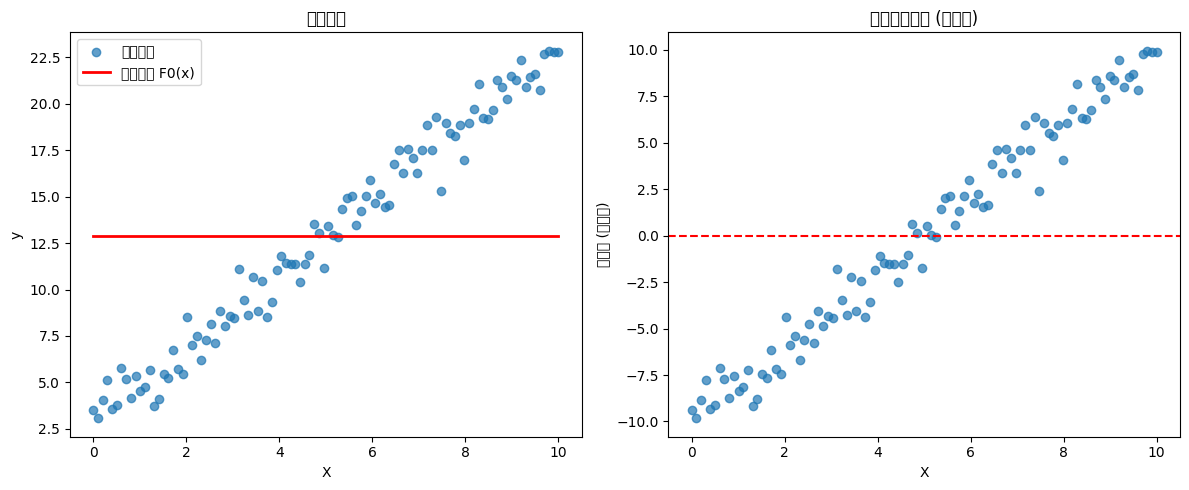

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# 创建一个简单的示例
np.random.seed(42)
X = np.linspace(0, 10, 100)
y = 2 * X + 3 + np.random.normal(0, 1, 100)  # y = 2x + 3 + noise

# 初始化
F0 = np.mean(y) * np.ones_like(X)  # 初始预测：所有样本预测为均值

# 计算第一轮的伪残差（负梯度）
residuals1 = y - F0

print("第一轮伪残差计算:")
print(f"样本1: y = {y[0]:.3f}, F0(x) = {F0[0]:.3f}, 伪残差 = {residuals1[0]:.3f}")
print(f"样本2: y = {y[1]:.3f}, F0(x) = {F0[1]:.3f}, 伪残差 = {residuals1[1]:.3f}")

# 绘制图表
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X, y, alpha=0.7, label='真实数据')
plt.plot(X, F0, 'r-', linewidth=2, label='初始预测 F0(x)')
plt.xlabel('X')
plt.ylabel('y')
plt.title('初始预测')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(X, residuals1, alpha=0.7)
plt.xlabel('X')
plt.ylabel('伪残差 (负梯度)')
plt.title('第一轮伪残差 (负梯度)')
plt.axhline(y=0, color='r', linestyle='--')

plt.tight_layout()
plt.show()



## GBDT vs 神经网络反向传播

现在让我们对比一下GBDT的梯度计算和神经网络的反向传播：

| 特性 | GBDT (梯度提升决策树) | 神经网络 (反向传播) |
|------|---------------------|-------------------|
| **优化空间** | **函数空间**：优化的是函数F(x)本身 | **参数空间**：优化的是权重和偏置参数 |
| **梯度计算** | 计算损失函数对**当前预测值F(x)**的梯度 | 计算损失函数对**网络参数(权重)**的梯度 |
| **"参数"更新** | 添加一个新的函数(决策树)到模型中：<br>$F_m(x) = F_{m-1}(x) + \nu h_m(x)$ | 更新权重参数：<br>$W^{(l)} = W^{(l)} - \eta \frac{\partial L}{\partial W^{(l)}}$ |
| **梯度用途** | 作为新决策树的**目标值**来拟合 | 用于直接**更新权重参数** |
| **模型形式** | 加性模型：$F(x) = \sum_{m=0}^M \nu h_m(x)$ | 复合函数：$f(x) = \sigma_n(W_n \cdots \sigma_1(W_1 x + b_1) \cdots + b_n)$ |
| **训练方式** | **序列化**：一棵树接一棵树地训练 | **并行化**：所有参数同时更新 |
| **可解释性** | 相对较好，可以看到特征重要性 | 较差，黑盒模型 |

### 关键区别的数学表达

**神经网络（反向传播）**：
$$
\frac{\partial L}{\partial W_{ij}^{(l)}} = \frac{\partial L}{\partial z_j^{(l+1)}} \cdot \frac{\partial z_j^{(l+1)}}{\partial W_{ij}^{(l)}}
$$
其中 $z_j^{(l+1)} = \sigma(\sum_i W_{ij}^{(l)} a_i^{(l)} + b_j^{(l)})$

**GBDT**：
$$
-\frac{\partial L(y_i, F(x_i))}{\partial F(x_i)} \bigg|_{F(x)=F_{m-1}(x)}
$$
这个梯度值被用作新决策树的学习目标。

## 不同损失函数的梯度计算

GBDT的强大之处在于它可以处理各种损失函数。不同损失函数的梯度计算如下：

### 1. 平方损失 (回归)
$L(y, F) = \frac{1}{2}(y - F)^2$
负梯度：$-\frac{\partial L}{\partial F} = y - F$

### 2. 绝对损失 (回归)
$L(y, F) = |y - F|$
负梯度：$-\frac{\partial L}{\partial F} = \text{sign}(y - F)$

### 3. 二分类对数损失 (逻辑回归)
$L(y, F) = y \cdot \log(1 + e^{-F}) + (1-y) \cdot \log(1 + e^{F})$
负梯度：$-\frac{\partial L}{\partial F} = y - \frac{1}{1 + e^{-F}}$

### 4. 多分类对数损失
$L(y, F) = -\sum_{k=1}^K y_k \log p_k$
其中 $p_k = \frac{e^{F_k}}{\sum_{j=1}^K e^{F_j}}$
负梯度：$-\frac{\partial L}{\partial F_k} = y_k - p_k$

## 代码示例：手动实现简单的GBDT梯度计算


In [ ]:

import numpy as np

# 定义不同的损失函数和它们的梯度
def squared_loss(y, F):
    """平方损失函数及其梯度"""
    loss = 0.5 * (y - F) ** 2
    gradient = -(y - F)  # 负梯度
    return loss, gradient

def absolute_loss(y, F):
    """绝对损失函数及其梯度"""
    loss = np.abs(y - F)
    gradient = -np.sign(y - F)  # 负梯度
    return loss, gradient

def logistic_loss(y, F):
    """逻辑损失函数及其梯度（用于二分类）"""
    # 将F转换到概率
    p = 1 / (1 + np.exp(-F))
    loss = -y * np.log(p) - (1 - y) * np.log(1 - p)
    gradient = -(y - p)  # 负梯度
    return loss, gradient

# 示例计算
y_true = 5.0
F_current = 3.0  # 当前模型的预测

# 计算不同损失函数的梯度
loss_sq, grad_sq = squared_loss(y_true, F_current)
loss_abs, grad_abs = absolute_loss(y_true, F_current)
loss_log, grad_log = logistic_loss(1, F_current)  # 假设真实类别为1

print(f"真实值: {y_true}, 当前预测: {F_current}")
print(f"平方损失: 损失 = {loss_sq:.3f}, 负梯度 = {grad_sq:.3f}")
print(f"绝对损失: 损失 = {loss_abs:.3f}, 负梯度 = {grad_abs:.3f}")
print(f"逻辑损失: 损失 = {loss_log:.3f}, 负梯度 = {grad_log:.3f}")


## 总结

1. **GBDT确实使用梯度**，但是是在**函数空间**中而不是参数空间中。

2. **计算方式不同**：
   - 神经网络：计算损失对权重参数的梯度，用于直接更新参数
   - GBDT：计算损失对当前预测值的梯度，作为新决策树的学习目标

3. **核心直觉**：GBDT的每一步都在尝试添加一个新函数（决策树）来"修正"当前模型在梯度方向上的错误。

4. **灵活性**：GBDT可以通过选择不同的损失函数来处理各种任务（回归、分类、排序等）。

这种在函数空间中的梯度下降方法是GBDT如此强大和灵活的根本原因，也是它与其他梯度基优化算法的本质区别。